In [1]:
.libPaths( c(.libPaths(), "/Library/Frameworks/R.framework/Versions/4.0/Resources/library"))

In [2]:
library(randomForest)
library(caret)
library(ROCR)
library(pROC)
library(stepPlr)
library(doMC)
library(xtable)
library(LiblineaR)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [3]:
pred_data <- read.csv(file="./data/SambanisImp.csv")
causal_mech_data <- read.csv(file="./data/Amelia.Imp3.csv")

In [4]:
africa_data <- read.csv(file="./data/AfricaImp.csv")

In [5]:
insample_data <- pred_data[pred_data$year <= 1989, ] 
outsample_data <- pred_data[pred_data$year > 1989, ]

In [6]:
nrow(insample_data)
nrow(outsample_data)

[1] 5299

[1] 1841

In [7]:
# Using only the 88 variables specified in Sambanis (2006) Appendix

v88 <- c("warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
      "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
      "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel",
      "durable", "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590",
      "expgdp", "exrec", "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2",
      "geo34", "geo57", "geo69", "geo8", "illiteracy", "incumb", "infant",
      "inst", "inst3", "life", "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper",
      "mirps0", "mirps1", "mirps2", "mirps3", "nat_war", "ncontig",
      "nmgdp", "nmdp4_alt", "numlang", "nwstate", "oil", "p4mchg",
      "parcomp", "parreg", "part", "partfree", "plural", "plurrel",
      "pol4", "pol4m", "pol4sq", "polch98", "polcomp", "popdense",
      "presi", "pri", "proxregc", "ptime", "reg", "regd4_alt", "relfrac", "seceduc",
      "second", "semipol3", "sip2", "sxpnew", "sxpsq", "tnatwar", "trade",
      "warhist", "xconst")

pred_data.insample <- insample_data[, v88]
pred_data.outsample <- outsample_data[, v88]

In [8]:
# Convert DV into Factor with names for Caret Library
pred_data.insample$warstds <- factor(
    pred_data.insample$warstds,
    levels=c(0,1),
    labels=c("peace", "war"))

pred_data.outsample$warstds <- factor(
    pred_data.outsample$warstds,
    levels=c(0,1),
    labels=c("peace", "war"))

In [9]:
# distribute workload over multiple cores for faster computation
registerDoMC(cores=7)
set.seed(666)

In [10]:
tc <- trainControl(method="cv",
    number=10,
    summaryFunction=twoClassSummary,
    classProb=T,
    savePredictions=T)

In [117]:
model.fl.1 <- train(
    as.factor(warstds)~warhist+ln_gdpen+lpopns+lmtnest+ncontig+oil+nwstate
                      +inst3+pol4+ef+relfrac, #FL 2003 model spec
    metric="ROC", method="glm", family="binomial", trControl=tc, data=pred_data.insample)

model.fl.2 <- train(
    as.factor(warstds)~warhist+ln_gdpen+lpopns+lmtnest+ncontig+oil+nwstate
                      +inst3+pol4+ef+relfrac, #FL 2003 model spec
    metric="ROC", method="plr", trControl=tc, data=pred_data.insample)

In [120]:
model.ch.1 <- train(
    as.factor(warstds)~sxpnew+sxpsq+ln_gdpen+gdpgrowth+warhist+lmtnest+ef+popdense
                      +lpopns+coldwar+seceduc+ptime,
    metric="ROC", method="glm", family="binomial", trControl=tc, data=pred_data.insample)

model.ch.2 <- train(
    as.factor(warstds)~sxpnew+sxpsq+ln_gdpen+gdpgrowth+warhist+lmtnest+ef+popdense
                      +lpopns+coldwar+seceduc+ptime,
    metric="ROC", method="plr", trControl=tc, data=pred_data.insample)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


Convergence warning in plr: 2 


In [121]:
model.hs.1 <- train(
    warstds~lpopns+ln_gdpen+inst3+parreg+geo34+proxregc+gdpgrowth+anoc
           +partfree+nat_war+lmtnest+decade1+pol4sq+nwstate+regd4_alt+etdo4590+milper
           +geo1+tnatwar+presi,
    metric="ROC", method="glm", family="binomial", trControl=tc, data=pred_data.insample)
model.hs.2 <- train(
    warstds~lpopns+ln_gdpen+inst3+parreg+geo34+proxregc+gdpgrowth+anoc
           +partfree+nat_war+lmtnest+decade1+pol4sq+nwstate+regd4_alt+etdo4590+milper
           +geo1+tnatwar+presi,
    metric="ROC", method="plr", trControl=tc, data=pred_data.insample)


Convergence warning in plr: 2 


In [149]:
model.rf <- train(
    as.factor(warstds)~.,
    metric="ROC", method="rf",
    sampsize=c(20,80),
    importance=T,
    proximity=F, 
    ntree=1000,
    trControl=tc, data=pred_data.insample)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

In [11]:
get_re <- function(mm, insample, outsample) {
    fl.pred.in<-predict(mm, newdata=insample, type="prob")
    fl.pred.out<-predict(mm, newdata=outsample, type="prob")
    fl.pred.in<-as.data.frame(fl.pred.in)
    fl.pred.out<-as.data.frame(fl.pred.out)
    fl.perf.in<-prediction(fl.pred.in$war, insample$warstds)
    fl.perf.in.auc<-performance(fl.perf.in, "auc")
    fl.perf.in.tfpr <- performance(fl.perf.in,"tpr","fpr")
    fl.perf.out<-prediction(fl.pred.out$war, outsample$warstds)
    fl.perf.out.auc<-performance(fl.perf.out, "auc")
    fl.perf.out.tfpr <- performance(fl.perf.out,"tpr","fpr")
    re = list("in.auc" = fl.perf.in.auc, "in.tfpr" = fl.perf.in.tfpr, 
              "out.auc" = fl.perf.out.auc, "out.tfpr" = fl.perf.out.tfpr)
    return(re)
}



In [150]:
model.rf.re = get_re(model.rf, pred_data.insample, pred_data.outsample)

In [151]:
model.fl.1.re = get_re(model.fl.1, pred_data.insample, pred_data.outsample)
model.fl.2.re = get_re(model.fl.2, pred_data.insample, pred_data.outsample)
model.ch.1.re = get_re(model.ch.1, pred_data.insample, pred_data.outsample)
model.ch.2.re = get_re(model.ch.2, pred_data.insample, pred_data.outsample)
model.hs.1.re = get_re(model.hs.1, pred_data.insample, pred_data.outsample)
model.hs.2.re = get_re(model.hs.2, pred_data.insample, pred_data.outsample)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”

In [152]:
model.fl.1.re$in.auc@y.values
model.fl.1.re$out.auc@y.values
model.ch.1.re$in.auc@y.values
model.ch.1.re$out.auc@y.values
model.hs.1.re$in.auc@y.values
model.hs.1.re$out.auc@y.values
model.rf.re$in.auc@y.values
model.rf.re$out.auc@y.values

[[1]]
[1] 0.7888383

[[1]]
[1] 0.7853794

[[1]]
[1] 0.837625

[[1]]
[1] 0.8460523

[[1]]
[1] 0.8318723

[[1]]
[1] 0.8233591

[[1]]
[1] 0.9697264

[[1]]
[1] 0.8878536

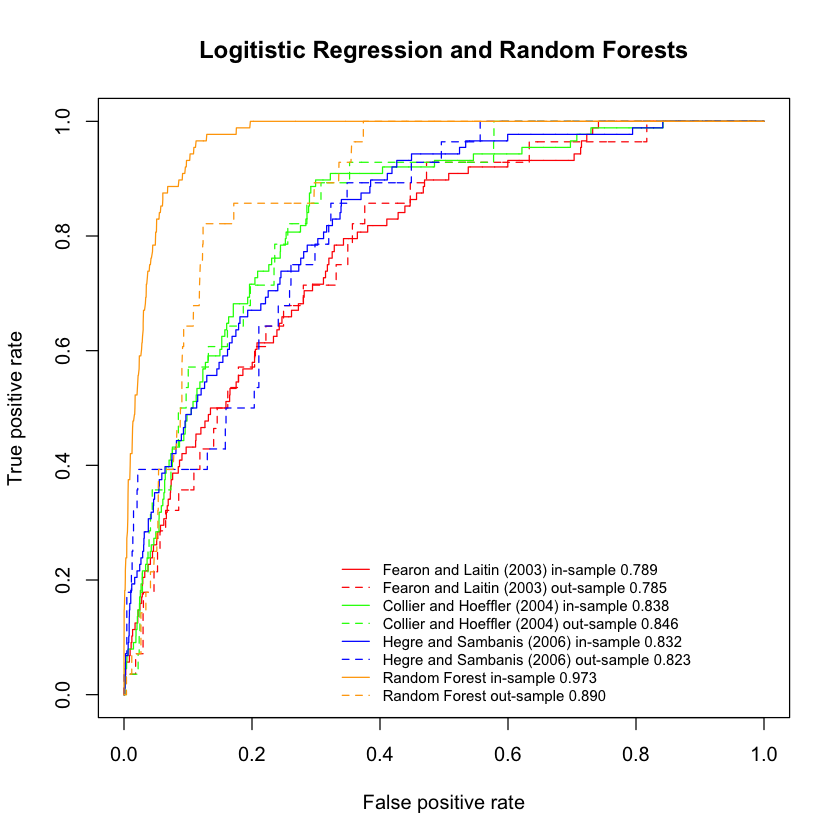

In [158]:
plot(model.fl.1.re$in.tfpr, col="red", main="Logitistic Regression and Random Forests")
plot(model.fl.1.re$out.tfpr, add=T, lty=2, col="red")
plot(model.ch.1.re$in.tfpr, add=T, lty=1, col="green")
plot(model.ch.1.re$out.tfpr, add=T, lty=2, col="green")
plot(model.hs.1.re$in.tfpr, add=T, lty=1, col="blue")
plot(model.hs.1.re$out.tfpr, add=T, lty=2, col="blue")
plot(model.rf.re$in.tfpr, add=T, lty=1, col="orange")
plot(model.rf.re$out.tfpr, add=T, lty=2, col="orange")
legend(0.32, 0.25, 
       c("Fearon and Laitin (2003) in-sample 0.789", 
         "Fearon and Laitin (2003) out-sample 0.785",
         "Collier and Hoeffler (2004) in-sample 0.838",
         "Collier and Hoeffler (2004) out-sample 0.846",
         "Hegre and Sambanis (2006) in-sample 0.832", 
         "Hegre and Sambanis (2006) out-sample 0.823",
         "Random Forest in-sample 0.973",
         "Random Forest out-sample 0.890"),
       lty=c(1,2,1,2,1,2,1,2), col=c("red", "red", "green", "green", "blue", "blue", "orange", "orange"), bty="n", cex = .75)

In [189]:
model.fl.2.re$in.auc@y.values
model.fl.2.re$out.auc@y.values
model.ch.2.re$in.auc@y.values
model.ch.2.re$out.auc@y.values
model.hs.2.re$in.auc@y.values
model.hs.2.re$out.auc@y.values
model.rf.re$in.auc@y.values
model.rf.re$out.auc@y.values

[1] "0.788759791350456 haha"

[[1]]
[1] 0.7853006

[[1]]
[1] 0.7775553

[[1]]
[1] 0.6817824

[[1]]
[1] 0.8201663

[[1]]
[1] 0.8213892

[[1]]
[1] 0.9697264

[[1]]
[1] 0.8878536

In [209]:

png(file= paste("test", ".png", sep=""), width=600, height=600)
plot(model.fl.2.re$in.tfpr, col="red", main="Penalized Logitistic Regression and Random Forests")
plot(model.fl.2.re$out.tfpr, add=T, lty=2, col="red")
plot(model.ch.2.re$in.tfpr, add=T, lty=1, col="green")
plot(model.ch.2.re$out.tfpr, add=T, lty=2, col="green")
plot(model.hs.2.re$in.tfpr, add=T, lty=1, col="blue")
plot(model.hs.2.re$out.tfpr, add=T, lty=2, col="blue")
plot(model.rf.re$in.tfpr, add=T, lty=1, col="orange")
plot(model.rf.re$out.tfpr, add=T, lty=2, col="orange")
legend(0.32, 0.25, 
       c(paste("Fearon and Laitin (2003) in-sample", round(model.fl.2.re$in.auc@y.values[[1]], 3)), 
         "Fearon and Laitin (2003) out-sample 0.785",
         "Collier and Hoeffler (2004) in-sample 0.838",
         "Collier and Hoeffler (2004) out-sample 0.846",
         "Hegre and Sambanis (2006) in-sample 0.832", 
         "Hegre and Sambanis (2006) out-sample 0.823",
         "Random Forest in-sample 0.973",
         "Random Forest out-sample 0.890"),
       lty=c(1,2,1,2,1,2,1,2), col=c("red", "red", "green", "green", "blue", "blue", "orange", "orange"), bty="n", cex = .75)
dev.off()

pdf 
  2

In [164]:
colnames(pred_data)

[1] "cowcode"         "year"            "warstds"         "ptime"          
  [5] "yrint"           "autonomy"        "rf"              "popdense"       
  [9] "auto98"          "dem98"           "pol98"           "army85"         
 [13] "milgnp92"        "milper"          "milex"           "trade"          
 [17] "logpop"          "ienergy"         "ienercap"        "lnienc"         
 [21] "gdpmkt"          "gdpcap"          "irgdp"           "decade"         
 [25] "regy"            "neth_war"        "nmgdp"           "nmie"           
 [29] "nmdie"           "autch98"         "demch98"         "polch98"        
 [33] "moslem"          "christ"          "jewish"          "eastorth"       
 [37] "hindu"           "buddhist"        "sinic"           "indi_ani"       
 [41] "atheist"         "other"           "rgdpch"          "gdppp"          
 [45] "rgdpa_"          "lngdp_"          "rgdppca"         "expgdp"         
 [49] "primexp"         "sxpold"          "sxpnew"          "sxpnew100"      
 [53] "agexp"           "fuelexp"         "manuexp"         "nmp4"           
 [57] "nmp4l"           "nmdp4l"          "nmp4m"           "nmp4ml"         
 [61] "nmdp4ml"         "p4mchg"          "period5"         "ptwds"          
 [65] "fedpol3"         "semipol3"        "centpol3"        "autdpi"         
 [69] "munidpi"         "statedpi"        "authdpi"         "stcondpi"       
 [73] "primeg"          "seceduc"         "pri"             "sec"            
 [77] "secm"            "educyrs"         "primeduc"        "higheduc"       
 [81] "xrreg"           "xrcomp"          "xropen"          "xconst"         
 [85] "parreg"          "parcomp"         "polcomp"         "partfree"       
 [89] "major"           "presi"           "incumb"          "inst"           
 [93] "lmtnest"         "oil"             "anoc"            "dem"            
 [97] "elfo2"           "ethfrac2"        "warhist"         "warhist2cow"    
[101] "wwgdpcap"        "mirps"           "sip2"            "gdpgrowth"      
[105] "avgnabo"         "part"            "illiteracy"      "pregch"         
[109] "warstns"         "warstnsb"        "atwarns"         "yrbeg"          
[113] "mobeg"           "yrend"           "moend"           "ehet"           
[117] "drace"           "dlang"           "drel"            "popns"          
[121] "pgrowth"         "popdensi"        "illit"           "illitm"         
[125] "infant"          "life"            "energy"          "irst"           
[129] "elfo"            "etdo4590"        "auto4"           "dem4"           
[133] "pol4"            "pol4m"           "nmpol4m"         "nmpol4m2"       
[137] "geo"             "gdpen"           "gdpgro"          "gdpgro3"        
[141] "mtnest"          "ncontig"         "ethfrac"         "ef"             
[145] "plural"          "second"          "numlang"         "relfrac"        
[149] "plurrel"         "muslim"          "nwstate"         "instab"         
[153] "anocl1"          "ssafrica"        "reg"             "ager"           
[157] "reginst"         "durable"         "exrec"           "exconst"        
[161] "exrecm"          "exconstm"        "iexrec"          "iexcon"         
[165] "polity2"         "durable2"        "xrreg2"          "xrcomp2"        
[169] "xropen2"         "xconst2"         "parreg2"         "exrec2"         
[173] "exconst2"        "polcomp2"        "poldiff"         "inst2"          
[177] "inst3"           "fuel"            "ifuel"           "oil2"           
[181] "ld_warstns"      "ld_warstnsb"     "ld_instab"       "ld_inst2"       
[185] "ld_inst3"        "ln_gdpen"        "lpopns"          "coldwar"        
[189] "anoc2"           "lnmtn"           "warnsl1"         "auto4l1"        
[193] "pol4l1"          "dem4l1"          "pol4ml1"         "regd4ml1"       
[197] "coldl1"          "lpopnsl1"        "gdpl1"           "grol1"          
[201] "oil2l1"          "illitl1"         "infal1"          "pdensl1"        
[205] "ef1"             

In [166]:
colnames(causal_mech_data)

[1] "X"          "country"    "year"       "warstds"    "atwards"   
 [6] "anoc"       "ager"       "autonomy"   "avgnabo"    "dem"       
[11] "dlang"      "drace"      "drel"       "durable"    "ef"        
[16] "gdpgrowth"  "illiteracy" "infant"     "inst"       "inst3"     
[21] "life"       "lmtnest"    "milper"     "nat_war"    "ncontig"   
[26] "nwstate"    "oil"        "plural"     "plurrel"    "pol4"      
[31] "pol4sq"     "popdense"   "relfrac"    "seceduc"    "second"    
[36] "sxpnew"     "sxpsq"      "tnatwar"    "trade"      "warhist"   
[41] "xconst"     "lpopns"     "ln_gdpen"   "numlang"    "proxregc"  
[46] "partfree"   "decade1"    "regd4_alt"  "etdo4590"   "geo1"      
[51] "presi"      "parreg"     "geo34"

In [178]:
for (val in unique(pred_data$cowcode)) {
    
}



In [14]:
get_plot <- function(val, pred_data) {
outsample <- pred_data[pred_data$cowcode == val, ] 
insample <- pred_data[pred_data$cowcode != val, ]
outsample <- outsample[, v88]
insample <- insample[, v88]
    
insample$warstds <- factor(
insample$warstds,
levels=c(0,1),
labels=c("peace", "war"))

outsample$warstds <- factor(
    outsample$warstds,
    levels=c(0,1),
    labels=c("peace", "war"))
    
model.fl <- train(
    as.factor(warstds)~warhist+ln_gdpen+lpopns+lmtnest+ncontig+oil+nwstate
                      +inst3+pol4+ef+relfrac, #FL 2003 model spec
    metric="ROC", method="glm", family="binomial", trControl=tc, data=insample)

model.ch <- train(
    as.factor(warstds)~sxpnew+sxpsq+ln_gdpen+gdpgrowth+warhist+lmtnest+ef+popdense
                      +lpopns+coldwar+seceduc+ptime,
    metric="ROC", method="glm", family="binomial", trControl=tc, data=insample)

model.hs <- train(
    warstds~lpopns+ln_gdpen+inst3+parreg+geo34+proxregc+gdpgrowth+anoc
           +partfree+nat_war+lmtnest+decade1+pol4sq+nwstate+regd4_alt+etdo4590+milper
           +geo1+tnatwar+presi,
    metric="ROC", method="glm", family="binomial", trControl=tc, data=insample)

model.rf <- train(
    as.factor(warstds)~.,
    metric="ROC", method="rf",
    sampsize=c(20,80),
    importance=T,
    proximity=F, 
    ntree=1000,
    trControl=tc, data=insample)

model.fl.re = get_re(model.fl, insample, outsample)
model.ch.re = get_re(model.ch, insample, outsample)
model.hs.re = get_re(model.hs, insample, outsample)
model.rf.re = get_re(model.rf, insample, outsample)

png(file= paste(val, ".png", sep=""), width=600, height=600)
plot(model.fl.re$in.tfpr, col="red", main=paste("Logitistic Regression and Random Forests", val))
plot(model.fl.re$out.tfpr, add=T, lty=2, col="red")
plot(model.ch.re$in.tfpr, add=T, lty=1, col="green")
plot(model.ch.re$out.tfpr, add=T, lty=2, col="green")
plot(model.hs.re$in.tfpr, add=T, lty=1, col="blue")
plot(model.hs.re$out.tfpr, add=T, lty=2, col="blue")
plot(model.rf.re$in.tfpr, add=T, lty=1, col="orange")
plot(model.rf.re$out.tfpr, add=T, lty=2, col="orange")
legend(0.32, 0.25, 
       c(paste("Fearon and Laitin (2003) in-sample", round(model.fl.re$in.auc@y.values[[1]], 3)), 
         paste("Fearon and Laitin (2003) out-sample", round(model.fl.re$out.auc@y.values[[1]], 3)),
         paste("Collier and Hoeffler (2004) in-sample", round(model.ch.re$in.auc@y.values[[1]], 3)),
         paste("Collier and Hoeffler (2004) out-sample", round(model.ch.re$out.auc@y.values[[1]], 3)),
         paste("Hegre and Sambanis (2006) in-sample", round(model.hs.re$in.auc@y.values[[1]], 3)),
         paste("Hegre and Sambanis (2006) out-sample", round(model.hs.re$out.auc@y.values[[1]], 3)),
         paste("Random Forest in-sample", round(model.rf.re$in.auc@y.values[[1]], 3)),
         paste("Random Forest out-sample", round(model.rf.re$out.auc@y.values[[1]], 3))),
       lty=c(1,2,1,2,1,2,1,2), col=c("red", "red", "green", "green", "blue", "blue", "orange", "orange"), bty="n", cex = .75)
dev.off()
return (c(model.fl.re, model.ch.re, model.hs.re, model.rf.re))
}



In [ ]:
for (val in unique(pred_data$cowcode))
{
get_plot(val, pred_data)
print(paste(val, "done!"))
}

In [16]:
val = 500
re_500 = get_plot(val, pred_data)
print(paste(500, "done!"))

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] "500 done!"


In [15]:
val = 850
re_850 = get_plot(val, pred_data)
print(paste(850, "done!"))

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] "850 done!"


In [17]:
val = 404
re_404 = get_plot(val, pred_data)
print(paste(404, "done!"))

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] "404 done!"


In [18]:
val = 490
re_490 = get_plot(val, pred_data)
print(paste(490, "done!"))

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] "490 done!"


In [261]:
for (val in unique(pred_data$cowcode)) {
outsample <- pred_data[pred_data$cowcode == val, ] 
print(paste(val, nrow(outsample), sum(outsample$warstds)))
}


[1] "700 56 1"
[1] "339 56 0"
[1] "615 38 2"
[1] "540 26 1"
[1] "160 56 1"
[1] "371 10 0"
[1] "900 56 0"
[1] "305 56 0"
[1] "373 10 1"
[1] "31 28 0"
[1] "692 30 0"
[1] "771 30 1"
[1] "53 35 0"
[1] "370 10 0"
[1] "211 56 0"
[1] "80 20 0"
[1] "434 41 0"
[1] "760 30 0"
[1] "145 56 1"
[1] "346 10 1"
[1] "571 35 0"
[1] "140 56 0"
[1] "355 56 0"
[1] "439 41 0"
[1] "516 39 4"
[1] "811 48 2"
[1] "471 41 0"
[1] "20 56 0"
[1] "402 26 0"
[1] "482 41 1"
[1] "483 41 1"
[1] "155 56 0"
[1] "710 56 3"
[1] "100 56 2"
[1] "581 26 0"
[1] "484 41 1"
[1] "94 56 1"
[1] "344 9 1"
[1] "40 56 1"
[1] "352 41 2"
[1] "315 48 0"
[1] "316 8 0"
[1] "390 56 0"
[1] "522 24 1"
[1] "42 56 1"
[1] "130 56 0"
[1] "651 56 0"
[1] "92 56 1"
[1] "531 8 0"
[1] "366 10 0"
[1] "530 50 1"
[1] "529 6 0"
[1] "950 31 0"
[1] "375 56 0"
[1] "220 56 0"
[1] "481 41 0"
[1] "420 36 0"
[1] "372 10 1"
[1] "260 46 0"
[1] "255 10 0"
[1] "452 44 0"
[1] "350 56 0"
[1] "55 27 0"
[1] "90 56 3"
[1] "438 43 0"
[1] "404 27 1"
[1] "110 35 0"
[1] "41 5

In [248]:
unique(pred_data$cowcode)

[1] 700 339 615 540 160 371 900 305 373  31 692 771  53 370 211  80 434 760
 [19] 145 346 571 140 355 439 516 811 471  20 402 482 483 155 710 100 581 484
 [37]  94 344  40 352 315 316 390 522  42 130 651  92 531 366 530 529 950 375
 [55] 220 481 420 372 260 255 452 350  55  90 438 404 110  41  91 310 395 750
 [73] 850 630 645 205 666 325 437  51 740 663 705 501 732 690 703 812 367 660
 [91] 570 450 620 368 212 343 511 553 820 432 338 435 590  70 359 712 600 541
[109] 775 565 790 210 920  93 436 475 385 698 770  95 910 150 135 840 290 235
[127] 694 360 517 670 433 591 451 830 317 349 940 520 560 230 780 625 115 572
[145] 380 225 652 713 702 510 800 461  52 616 640 701 200   2 364 365 500 369
[163] 696 165 704 935 101 817 818 990 679 678 680 345 347 490 551 552